
=== Training MLP width=16 ===
[W=  16] ep 01 | train 0.328/90.22% | test 0.320/90.42%
[W=  16] ep 02 | train 0.261/92.14% | test 0.250/92.34%
[W=  16] ep 03 | train 0.230/93.11% | test 0.228/93.06%
[W=  16] ep 04 | train 0.202/93.88% | test 0.204/93.80%
[W=  16] ep 05 | train 0.190/94.30% | test 0.202/94.02%
[W=  16] ep 06 | train 0.167/94.97% | test 0.180/94.38%
[W=  16] ep 07 | train 0.160/95.27% | test 0.179/94.71%
[W=  16] ep 08 | train 0.157/95.27% | test 0.179/94.43%
[W=  16] ep 09 | train 0.150/95.51% | test 0.173/94.72%
[W=  16] ep 10 | train 0.139/95.87% | test 0.167/94.84%
[W=  16] ep 11 | train 0.129/96.06% | test 0.158/95.13%
[W=  16] ep 12 | train 0.128/96.12% | test 0.159/95.17%

=== Training MLP width=24 ===
[W=  24] ep 01 | train 0.293/91.37% | test 0.294/91.25%
[W=  24] ep 02 | train 0.230/93.26% | test 0.232/92.94%
[W=  24] ep 03 | train 0.187/94.50% | test 0.198/94.15%
[W=  24] ep 04 | train 0.165/94.99% | test 0.182/94.49%
[W=  24] ep 05 | train 0.135/95.98% | test

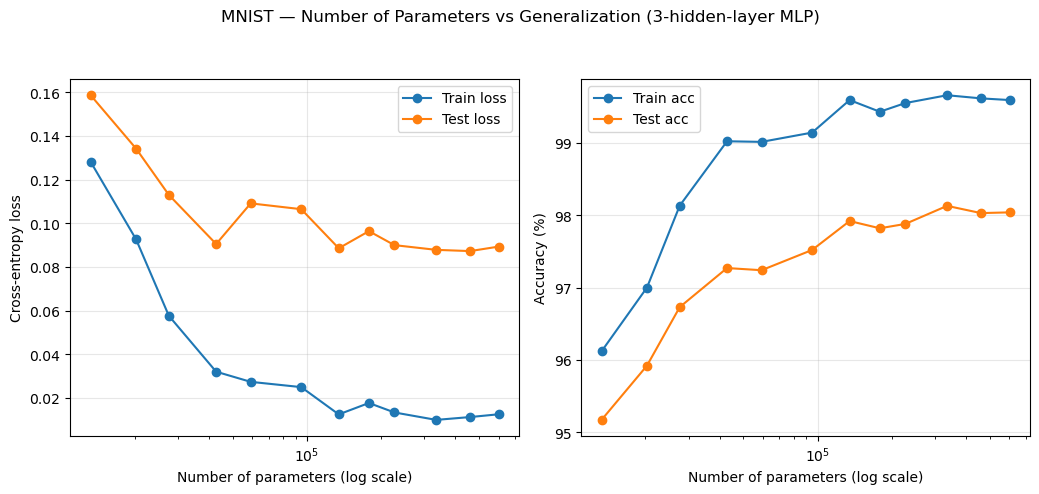

Saved figure to: hw1_3_params_vs_gen/mnist_params_vs_generalization.png


In [1]:
import os, random, numpy as np
import torch, torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
import pandas as pd
SEED = 2025
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTDIR = "hw1_3_params_vs_gen"; os.makedirs(OUTDIR, exist_ok=True)
EPOCHS       = 12              
BATCH_TRAIN  = 128
BATCH_TEST   = 256
LR           = 1e-3
WEIGHT_DECAY = 0.0             
PRINT_EVERY  = 1
tfm = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
train_ds = torchvision.datasets.MNIST("./data", train=True,  download=True, transform=tfm)
test_ds  = torchvision.datasets.MNIST("./data", train=False, download=True, transform= tfm)
train_ld = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_TEST,  shuffle=False, num_workers=2, pin_memory=True)
class MLPWidth(nn.Module):
    
    def __init__(self, width: int, in_dim=28*28, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, width), nn.ReLU(inplace=True),
            nn.Linear(width, width),  nn.ReLU(inplace=True),
            nn.Linear(width, width),  nn.ReLU(inplace=True),
            nn.Linear(width, num_classes)
        )
    def forward(self, x): return self.net(x)

def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * x.size(0)
        total += x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return loss_sum / total, 100.0 * correct / total

def train_one(width: int):# o
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

    model = MLPWidth(width).to(device)
    opt = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = nn.CrossEntropyLoss()

    for ep in range(1, EPOCHS + 1):
        model.train()
        for x, y in train_ld:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = crit(model(x), y)
            loss.backward(); opt.step()
        if ep % PRINT_EVERY == 0:
            tr_loss, tr_acc = evaluate(model, train_ld, crit)
            te_loss, te_acc = evaluate(model, test_ld,  crit)
            print(f"[W={width:4d}] ep {ep:02d} | "
                  f"train {tr_loss:.3f}/{tr_acc:5.2f}% | "
                  f"test {te_loss:.3f}/{te_acc:5.2f}%")

    P = count_params(model)
    tr_loss, tr_acc = evaluate(model, train_ld, crit)
    te_loss, te_acc = evaluate(model, test_ld,  crit)
    return {"width": width, "params": P,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "test_loss": te_loss,  "test_acc": te_acc}

# ------------------- Sweep widths (≥10) ----------------
widths = [16, 24, 32, 48, 64, 96, 128, 160, 192, 256, 320, 384]

records = []
for w in widths:
    print(f"\n=== Training MLP width={w} ===")
    rec = train_one(w)
    records.append(rec)

# Save table
df = pd.DataFrame(records).sort_values("params").reset_index(drop=True)
csv_path = os.path.join(OUTDIR, "metrics_params_vs_generalization.csv")
df.to_csv(csv_path, index=False)
print("\nSaved metrics to:", csv_path)
print(df)

# ------------------- Plots ---------------------------
params = df["params"].values
plt.figure(figsize=(10.5,5))
plt.suptitle("MNIST — Number of Parameters vs Generalization (3-hidden-layer MLP)")

plt.subplot(1,2,1)
plt.plot(params, df["train_loss"], marker="o", label="Train loss")
plt.plot(params, df["test_loss"],  marker="o", label="Test loss")
plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Cross-entropy loss")
plt.grid(alpha=0.3); plt.legend()

plt.subplot(1,2,2)
plt.plot(params, df["train_acc"], marker="o", label="Train acc")
plt.plot(params, df["test_acc"],  marker="o", label="Test acc")
plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Accuracy (%)")
plt.grid(alpha=0.3); plt.legend()

plt.tight_layout(rect=[0,0,1,0.93])
fig_path = os.path.join(OUTDIR, "mnist_params_vs_generalization.png")
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved figure to:", fig_path)
